In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import cvxpy as cp
import matplotlib.pyplot as plt
import pickle
from toolz import curry, partial
from scipy.linalg import block_diag
from functions_ssdid import fit_time_weights, calculate_regularization, fit_unit_weights, join_weights

# 1 - Read data

## 1.1 Spatial Weights Matrices from the states
- First-order queen contiguity matrices were generated for 4 US states: Alabama, Oregon, Pennsylvania and Wyoming



In [7]:
#Load file with Spatial Weights Matrices 
Matrix_states = pickle.load( open( "./Data/all_matrices.pkl", "rb" ) )


## 1.2 - Unemployment rate data
- Data are from the U.S. Bureau of Labor Statistics and contain monthly unemploment rate at the county level for all U.S. states from 1990 to 2019

In [9]:
#Read
df=pd.read_csv('./Data/BLS_county_employment.csv')
df.drop(['Employment', 'Labor_Force','countyname','Unemployment'], axis=1, inplace=True)
df.rename(columns={"FIPS": "ID"}, inplace=True)


#Restrict data for 3 years range 2002-2004
df=df[(df['year']>2001)&(df['year']<2005)]

#Create treatment and times columns (treatment occurs after the 24th month)
df['treatment']=False
df['after_treatment']=False
df.loc[df['year']==2004, 'after_treatment']=True

# Create separated data frames for each state, modify the format of the month column and save in a dictionary
Dict_states = {}

for state in Matrix_states.keys():
    state_df = df[df['state'] == state].reset_index(drop=True).sort_values(['year', 'month', 'ID'])
    state_df['month'] = np.repeat(np.arange(1, 37), len(state_df['ID'].unique()))
    Dict_states[state] = state_df.copy(deep=True)

# 2-Monte Carlo Simulation - Simulated spillover effect

- The example simulates an effect in a county in each iteration.
- Assume a tax incentive program was implemented in this county, and the effect was the reduction of the unemployment rate on the magnitude of 25%.
- Neighboring counties were also affected by the program,but in a smaller scale (50%).

## 2.1 Set parameters

In [12]:
states = ['WY','OR', 'PA','AL']

#List of estimands to be compared
list_estimands =['ATT_SyDID', 'ATT_SpDID', 'ATT_SpSyDID', 'AITE_SpDID','AITE_SpSyDID','ATT_SyDID_pct', 
                 'ATT_SpDID_pct', 'ATT_SpSyDID_pct', 'AITE_SpDID_pct','AITE_SpSyDID_pct']

# Number of treated units in each state (10%)
Dict_NT = {}
for state in Matrix_states.keys():
    Dict_NT[state] = round(len(Matrix_states[state])/10)

#Indirect effect (spillover)
rho=0.5
#Number of repetitions
reps = 1000

## 2.1 Simulations

In [13]:
BIAS = {state:{estimand:[] for estimand in list_estimands} for state in states}


#Outter loop: iterate across states
for state in states:
    print(state)

    #Get spatial weights matrix
    W=block_diag(*[Matrix_states[state]]*36)

   
    # Set seed to ensure reproducibility
    np.random.seed(123)

    for r in range(reps):

        ###############################
        ### ASSIGN TREATMENT EFFECT ###
        ###############################

        #Start new dataframe
        df_state = Dict_states[state].copy(deep=True)

        #Treated units
        
        TREATED = np.random.choice(list(df_state['ID'].unique()), replace=False, size=Dict_NT[state])
        
        #Doubel check to clean treatment column
        df_state['treatment'] = False
        
        #Assign treated units as treated
        df_state.loc[df_state['ID'].isin(TREATED), 'treatment']=True

        #Create interaction column
        df_state['interaction']=df_state['after_treatment']*df_state['treatment'] 

        #Column for spillover effect (spatial weights matrix x interaction)
        df_state['spillover']=W.dot(df_state['interaction'])

        #Create the effects (true ATT)
        ATT=-df_state['Unemployment_Rate'].mean()/4 #ATT of 25%

        #Direct effect (original series + ATT)
        df_state['UR']=df_state['Unemployment_Rate']+df_state['interaction']*ATT

        #Indirect effect (spillover)
        WD=df_state[df_state['spillover']>0]['spillover'].mean() #average proportion of treated neighbors
        AITE=ATT*rho*WD
        df_state['UR2']=df_state['UR']+df_state['spillover']*ATT*rho #modified Unemployment rate


        ############################
        ### ESTIMATE THE EFFECTS ###
        ############################

        ### Synthetic DiD ### 
        #####################


        ##### RESTRICT DONOR POOL EXCLUDING POSSIBLE INDIRECTLY AFFECTED UNITS #####
        data=df_state.copy(deep=True)
        affected=data[(data['spillover']>0)& (data['treatment']==False)] #Get the indirectly affected units at post-treatment periods
        affected=data[data['ID'].isin(affected['ID'].unique())] #Dataframe with indirectly affected units for all time
        data1=data[~data['ID'].isin(affected['ID'].unique())] #Dataframe with pure controls + treated unit

        ##### FIT WEIGHTS #####
        try:
            time_weights = fit_time_weights(data1,outcome_col="UR2",year_col="month",
                                    state_col="ID",treat_col="treatment",post_col="after_treatment")
            unit_weights = fit_unit_weights(data1,outcome_col="UR2",year_col="month",
                                    state_col="ID",treat_col="treatment",post_col="after_treatment")
        except: #for rare cases in which there is no pure control unit
            time_weights=pd.Series(np.repeat(1/(t/2),t/2), index=np.arange(10), name='time_weights')
            time_weights.index.name='month'
            n_non_treat=len(data1['ID'].unique())# Uniform weights to all units
            unit_weights=pd.Series(np.repeat(1/n_non_treat,n_non_treat),index=data1['ID'].unique(), name='unit_weights') #create series
            unit_weights.index.name='ID'
            print('temporary print')
            #print("no pure controls","n=",n,"i=",i)         

        did_data = join_weights(data1, unit_weights, time_weights,year_col="month",
                            state_col="ID",treat_col="treatment",post_col="after_treatment")
        
        ##### ESTIMATE SYNTHETIC DID #####
        X=did_data[['treatment','after_treatment','interaction']]
        Y=did_data['UR2']
        X=sm.add_constant(X) #adding constant
        X=X.replace([False,True],[0,1])
        try:
            model = sm.WLS(Y, X,weights=did_data["weights"]+1e-5).fit()
        except:
            model = sm.WLS(Y, X,weights=did_data["weights"]+1e-3).fit()

        bias_att_sydid = ATT - model.params.iloc[3]
        BIAS[state]['ATT_SyDID'].append(bias_att_sydid)
        BIAS[state]['ATT_SyDID_pct'].append(bias_att_sydid/ATT)
        


        ### Spatial Synthetic DiD ### 
        #############################

        ###Include back indirectly affected units
        affected=affected.assign(unit_weights=did_data[did_data['treatment']==1]['unit_weights'].mean())
        time_weights_complete=did_data.groupby('month').mean(numeric_only=True)['time_weights'].to_frame().reset_index()
        affected=pd.merge(affected, time_weights_complete, left_on='month', right_on='month')
        did_data2=pd.concat([did_data,affected]).sort_values(['month','ID'])
        did_data2['weights']=round(did_data2['unit_weights']*did_data2['unit_weights'],10)

        #LSDV APPROACH
        n=len(df_state['ID'].unique()) #number of units
        t=len(df_state['month'].unique()) #number of time periods
        new_df=pd.concat([pd.get_dummies(did_data2['ID'], prefix='ID'),pd.get_dummies(did_data2['month'], prefix='month'), did_data2],axis=1)
        Y=new_df['UR2']
        X=pd.concat([new_df[['interaction','spillover']],new_df.iloc[:,1:n+t-1] ],axis=1)
        X=sm.add_constant(X) #adding constant
        X=X.replace([False,True],[0,1])
        try:
            model2=sm.WLS(Y, X, weights=did_data2['weights']+1e-5).fit() 
        except:
            model2 = sm.WLS(Y, X,weights=did_data2["weights"]+1e-3).fit()
            print('convergence problem')

        bias_att_spsydid = ATT - model2.params.iloc[1]   
        bias_aite_spsydid = AITE - model2.params.iloc[2]*WD

        BIAS[state]['ATT_SpSyDID'].append(bias_att_spsydid)
        BIAS[state]['AITE_SpSyDID'].append( bias_aite_spsydid)
        BIAS[state]['ATT_SpSyDID_pct'].append(bias_att_spsydid/ATT)
        BIAS[state]['AITE_SpSyDID_pct'].append( bias_aite_spsydid/AITE)

        ### Spatial DiD ### 
        ###################

        model3 = sm.OLS(Y, X).fit()

        bias_att_spdid = ATT - model3.params.iloc[1]   
        bias_aite_spdid = AITE - model3.params.iloc[2]*WD

        BIAS[state]['ATT_SpDID'].append(bias_att_spdid)
        BIAS[state]['AITE_SpDID'].append( bias_aite_spdid)
        BIAS[state]['ATT_SpDID_pct'].append(bias_att_spdid/ATT)
        BIAS[state]['AITE_SpDID_pct'].append( bias_aite_spdid/AITE)
        #print('STATE=',state, 'AITE:', round(AITE,3), 'AITE_E_:',round(model3.params.iloc[2]*WD,3))
    print(ATT)
        


WY
-1.0367149758454108
OR


c:\Users\renan\anaconda3\envs\ssdid\lib\site-packages\statsmodels\regression\linear_model.py:774: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
c:\Users\renan\anaconda3\envs\ssdid\lib\site-packages\statsmodels\regression\linear_model.py:772: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


-2.039564043209876
PA
-1.4832918739635157
AL
-1.718407960199005


# 3 - Results

## 3.1 Bias (Table 2)

In [14]:
df_BIAS = pd.DataFrame(index=list_estimands, columns=states)

# Fill the DataFrame with the specified values
for state in states:
    for estimand in list_estimands:
        value = np.mean(BIAS[state][estimand])
        df_BIAS.at[estimand, state] = round(value,3)

df_BIAS

,WY,OR,PA,AL
ATT_SyDID,-0.005,0.107,0.163,0.124
ATT_SpDID,-0.003,0.007,0.01,0.016
ATT_SpSyDID,-0.019,-0.001,-0.004,0.032
AITE_SpDID,0.007,-0.003,0.013,-0.01
AITE_SpSyDID,-0.01,-0.012,-0.004,0.009
ATT_SyDID_pct,0.004,-0.052,-0.11,-0.072
ATT_SpDID_pct,0.003,-0.003,-0.007,-0.009
ATT_SpSyDID_pct,0.018,0.001,0.003,-0.019
AITE_SpDID_pct,-0.11,0.016,-0.078,0.055
AITE_SpSyDID_pct,0.026,0.055,0.013,-0.038


## 3.2 Distribution of errors - ATT (Figure 2)

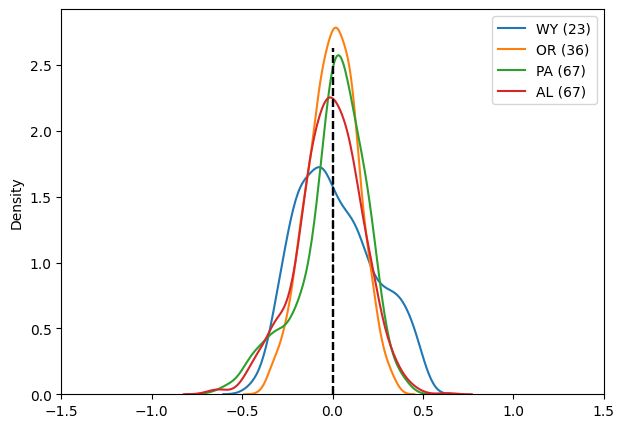

In [22]:
# Create the subplots
fig, ax = plt.subplots(1,1, figsize=(7, 5))

for state in states:
    sns.kdeplot(BIAS[state]['ATT_SpSyDID_pct'], label=f'{state} ({len(Matrix_states[state])})')
    ax.axvline(0, ymax=0.9, linestyle='--', color='black')
    ax.legend()
#plt.suptitle('ATT - Distribution of the errors', fontsize=16)
plt.legend()
plt.axvline(0, ymax=0.9, linestyle='--', color='black')
plt.xlim(-1.5,1.5);


## 3.3 Distribution of errors - AITE (Figure 3)

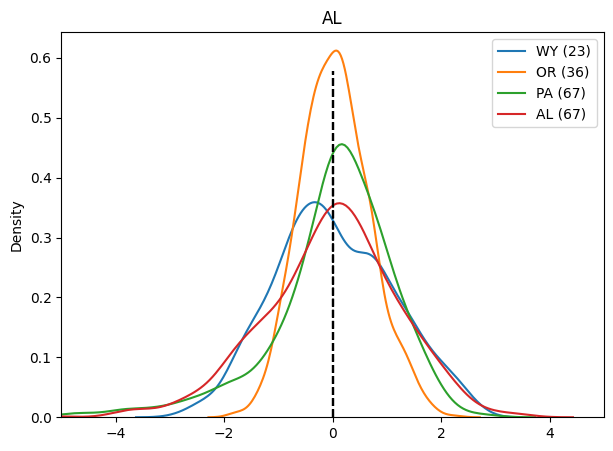

In [24]:
# Create the subplots
fig, ax = plt.subplots(1,1, figsize=(7, 5))

for state in states:
    sns.kdeplot(BIAS[state]['AITE_SpSyDID_pct'], label=f'{state} ({len(Matrix_states[state])})')
    ax.axvline(0, ymax=0.9, linestyle='--', color='black')
    ax.set_title(state)
    ax.legend()
#plt.suptitle('Distribution of the errors', fontsize=16)
plt.xlim(-5,5)
plt.legend()
plt.axvline(0, ymax=0.9, linestyle='--', color='black');